In [45]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls -l ./gdrive/MyDrive/Colab\ Notebooks/datasets

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 164239
-rw------- 1 root root     23875 Oct 17 04:57 diabetes2.csv
-rw------- 1 root root  33075636 Nov 18 08:26 test_data.csv
-rw------- 1 root root 135047556 Nov 18 08:26 train_data.csv
-rw------- 1 root root     32350 Nov 18 08:27 train_target.csv


In [46]:
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/train_data.csv', header=None)
target = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/train_target.csv', header=None)

In [47]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
count,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,...,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000,16175.000000
mean,115.174467,112.331314,109.551283,107.335703,105.389985,103.967790,103.429737,103.593138,104.382071,105.954498,...,106.485070,106.291561,106.346770,106.388810,106.667512,107.126059,107.967295,109.204389,110.221329,111.102380
std,80.537407,79.211493,78.218414,76.682974,75.302802,73.670423,72.246364,70.988322,69.982145,69.201706,...,69.202311,70.513357,71.417654,72.294698,73.238989,74.197439,75.209098,76.161001,76.665033,77.249353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.000000,42.000000,41.000000,41.000000,41.000000,41.000000,42.000000,43.000000,44.000000,46.000000,...,47.000000,45.000000,45.000000,44.000000,42.000000,42.000000,41.000000,41.000000,41.000000,42.000000
50%,103.000000,99.000000,95.000000,92.000000,90.000000,90.000000,90.000000,91.000000,94.000000,97.000000,...,100.000000,99.000000,98.000000,97.000000,97.000000,98.000000,98.000000,99.000000,101.000000,101.000000
75%,184.000000,178.000000,173.000000,167.000000,163.000000,159.000000,157.000000,156.000000,158.000000,159.000000,...,159.000000,160.000000,161.000000,163.000000,165.000000,167.000000,169.000000,172.000000,173.000000,175.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [48]:
target.describe()

,0
count,16175.000000
mean,1.059969
std,0.741875
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16175 entries, 0 to 16174
Columns: 2304 entries, 0 to 2303
dtypes: int64(2304)
memory usage: 284.3 MB


In [50]:
# get count for each class
target.squeeze().value_counts()

1    7215
2    4965
0    3995
Name: 0, dtype: int64

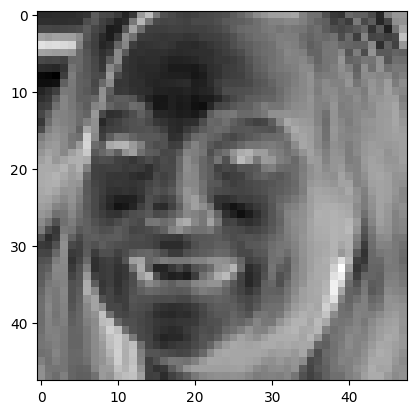

In [51]:
# display sample image

sample = data.iloc[0].to_numpy()
sample = sample.reshape(48, 48)
sample = sample.astype('uint8')*255
sample = Image.fromarray(sample)

plt.imshow(sample, cmap='gray')
plt.show()

In [52]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

# Create dataset
class CustomDatasetA3(Dataset):
  def __init__(self, train = True, transform = None, target_transform = None, rand = 42):
    super().__init__()
    self.train = train
    self.transform = transform
    self.target_transform = target_transform

    # read csv files
    X = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/train_data.csv', header=None).to_numpy()
    Y = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/train_target.csv', header=None).to_numpy().flatten()

    # split using seed
    train_data, validation_data, train_target, validation_target = train_test_split(X, Y, test_size=0.2, random_state=rand)

    # if train=True return train dataset, else return validation
    if self.train:
      self.data = train_data
      self.target = train_target
    else:
      self.data = validation_data
      self.target = validation_target

    # reshape to 48x48
    self.data = np.vstack(self.data).reshape(-1, 48, 48)

  def __getitem__(self, idx):
    img, target = self.data[idx], self.target[idx]
    # convert to PIL image
    img = Image.fromarray(img.astype('uint8')*255)

    # transform data and target
    if self.transform is not None:
      img = self.transform(img)
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img, target

  def __len__(self):
    return len(self.data)

In [53]:
dSet = CustomDatasetA3(train=True)

Test Dataset

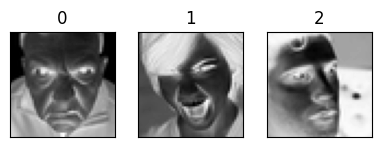

In [54]:
fig = plt.figure(figsize=(8,3))
num_classes = 3
# plot 1 image for each class
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(i)
    # get first image of the class from generator
    img = next(img for img, label in dSet if label == i)
    plt.imshow(img, cmap='gray')

plt.show()

In [55]:
# create train and validation dataset
from torchvision import transforms
import random

# get random seed for split
state = random.randint(0, 1000)

faces = CustomDatasetA3(train=True, transform=transforms.ToTensor(), rand=state)
faces_val = CustomDatasetA3(train=False, transform=transforms.ToTensor(), rand=state)

In [56]:
# create dataloader
train_loader = torch.utils.data.DataLoader(faces, batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(faces_val, batch_size=64, shuffle=False)

In [59]:
class Block(nn.Module):
  def __init__(self, n_chans):
    super(Block, self).__init__()
    self.conv1 = nn.Conv2d(n_chans, n_chans*2, kernel_size=3, padding='same')
    self.norm1 = nn.BatchNorm2d(num_features=n_chans*2)
    self.act1 = nn.ReLU()
    self.conv2 = nn.Conv2d(n_chans*2, n_chans*2, kernel_size=3, padding='same')
    self.norm2 = nn.BatchNorm2d(num_features=n_chans*2)
    self.act2 = nn.ReLU()
    self.conv3 = nn.Conv2d(n_chans*2, n_chans*2, kernel_size=3, padding='same')
    self.norm3 = nn.BatchNorm2d(num_features=n_chans*2)
    self.act3 = nn.ReLU()
    self.conv4 = nn.Conv2d(n_chans*2, n_chans*2, kernel_size=3, padding='same')
    self.norm4 = nn.BatchNorm2d(num_features=n_chans*2)
    self.act4 = nn.ReLU()
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    out = self.act1(self.norm1(self.conv1(x)))
    out1 = out
    out = self.act2(self.norm2(self.conv2(out)))
    out = self.act3(self.norm3(self.conv3(out)))
    out = self.act4(self.norm4(self.conv4(out)))
    out = self.pool(out + out1)
    return out

In [65]:
class Net(nn.Module):
  def __init__(self, n_chans=16, n_blocks=3):
    super().__init__()
    self.n_chans = n_chans
    self.conv1 = nn.Conv2d(1, n_chans, kernel_size=3, padding='same')
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)

    # default 3 pytorch block each with 2 times more input channels
    self.blocks = nn.Sequential(
        *[Block(n_chans=x) for x in [n_chans*(2**i) for i in range(n_blocks)]]
    )

    self.fc1 = nn.Linear(128 * 3 * 3, 1024)
    self.act10 = nn.ReLU()
    self.fc2 = nn.Linear(1024, 1024)
    self.act11 = nn.ReLU()
    self.fc3 = nn.Linear(1024, 1024)
    self.act12 = nn.ReLU()
    self.fc4 = nn.Linear(1024, 1024)
    self.act13 = nn.ReLU()
    self.fc5 = nn.Linear(1024, 3) # 3 classes, no activation function since using CrossEntropy

  def forward(self,x):
    out = self.act1(self.conv1(x))
    out = self.pool1(out)

    out = self.blocks(out)

    #print("shape: ", out.shape)

    out = out.view(-1, 128 * 3 * 3) # change to 1d
    out = self.act10(self.fc1(out))
    out = self.act11(self.fc2(out))
    out = self.act12(self.fc3(out))
    out = self.act13(self.fc4(out))
    out = self.fc5(out)
    return out

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()

model.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
      (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU()
      (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act4): ReLU(

In [62]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [63]:
# create optimizer ADAM
optimizer = optim.Adam(model.parameters())

# Use CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# Early stopping
early_stopper = EarlyStopper(patience=3, min_delta=0.3)

n_epochs = 100

for epoch in range(n_epochs):
    model.train(True)
    for imgs, labels in train_loader:
        # move to GPU
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)   # nn.Conv2d expects a B × C × H × W shaped tensor as input
        #print(outputs.shape)
        #print(labels.shape)
        train_loss = loss_fn(outputs, labels)

        # zero gradients
        optimizer.zero_grad()
        # backpropagation
        train_loss.backward()
        # update weight
        optimizer.step()

    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            # move to GPU
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            val_loss = loss_fn(outputs, labels)

            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    print("Epoch: %d, train_loss: %f, val_loss: %f, val_accuracy: %f" % (epoch, float(train_loss), float(val_loss), (correct / total)))

    # early stop
    # if early_stopper.early_stop(val_loss):
    #     break

Epoch: 0, train_loss: 0.821859, val_loss: 1.127442, val_accuracy: 0.554250
Epoch: 1, train_loss: 0.892170, val_loss: 0.977762, val_accuracy: 0.607110
Epoch: 2, train_loss: 0.694785, val_loss: 0.770873, val_accuracy: 0.682226
Epoch: 3, train_loss: 0.525085, val_loss: 0.881860, val_accuracy: 0.682226
Epoch: 4, train_loss: 0.217163, val_loss: 0.764711, val_accuracy: 0.693045
Epoch: 5, train_loss: 0.886294, val_loss: 0.685698, val_accuracy: 0.701391
Epoch: 6, train_loss: 0.786922, val_loss: 0.754701, val_accuracy: 0.711283
Epoch: 7, train_loss: 0.355951, val_loss: 0.420381, val_accuracy: 0.765379
Epoch: 8, train_loss: 0.399260, val_loss: 0.718451, val_accuracy: 0.768161
Epoch: 9, train_loss: 0.427898, val_loss: 0.739512, val_accuracy: 0.757651
Epoch: 10, train_loss: 0.352291, val_loss: 1.200614, val_accuracy: 0.682535
Epoch: 11, train_loss: 0.917923, val_loss: 0.676551, val_accuracy: 0.755487
Epoch: 12, train_loss: 0.076669, val_loss: 0.935651, val_accuracy: 0.701700
Epoch: 13, train_loss:

In [64]:
# get submission.csv file
id = []
category = []

test_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/test_data.csv', header=None).to_numpy()
row, col = test_data.shape
for i in range(row):
  # get each row and reshape to 48 x 48
  input = test_data[i].reshape(48, 48)
  input = Image.fromarray(input.astype('uint8')*255) # convert to PIL img

  # convert to tensor
  test_transform = transforms.ToTensor()
  input = test_transform(input)
  input = input.to(device)

  # detach from comp graph
  with torch.no_grad():
    output = model(input.unsqueeze(0)) # add batch dim
    id.append(i)
    pred = np.argmax(output.cpu().numpy()) # get index of largest
    category.append(pred)

# convert to DataFrame then to csv
submission = pd.DataFrame({'Id': id, "Category": category})
submission.to_csv("submission.csv", index=False)